In [1]:
# Imports
import numpy as np
import torch
from torch import nn
import lightning as L
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import Omniglot
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose, ToTensor, Resize
from lightning.pytorch.loggers import CSVLogger

import sys
sys.path.append('./Convolutional-KANs/kan_convolutional')
from KANLinear import *

# Martin setup copy :)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
L.seed_everything(628, workers=True)
torch.set_float32_matmul_precision('high')

Seed set to 628


# Data

In [2]:
# Dataset Setup
transform = Compose([
    Resize((28, 28)),
    ToTensor()
])

train_dataset = Omniglot(root="./temp/", background=True, download=True, transform=transform)
test_dataset = Omniglot(root="./temp/", background=False, download=True, transform=transform)

# Reformatted Dataset Class
class LCDataset(Dataset):
    def __init__(self, dataset, num_classes, limit=-1):
        self.limit = limit
        self.num_classes = num_classes
        if self.limit != -1:
            sub = list(np.random.permutation(np.arange(len(dataset)))[0:self.limit])
            self.dataset = Subset(dataset, sub)
        else:
            self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y_one_hot = torch.zeros(self.num_classes)
        y_one_hot[y] = 1
        return x, y_one_hot

batch_size = 64
num_classes = 1623  # Omniglot has 1,623 classes
ntk_loader = DataLoader(LCDataset(train_dataset, num_classes=num_classes, limit=500), batch_size=batch_size, num_workers=10)
train_loader = DataLoader(LCDataset(train_dataset, num_classes=num_classes), batch_size=batch_size, shuffle=True, num_workers=10)
test_loader = DataLoader(LCDataset(test_dataset, num_classes=num_classes), batch_size=batch_size, num_workers=10)

Files already downloaded and verified
Files already downloaded and verified


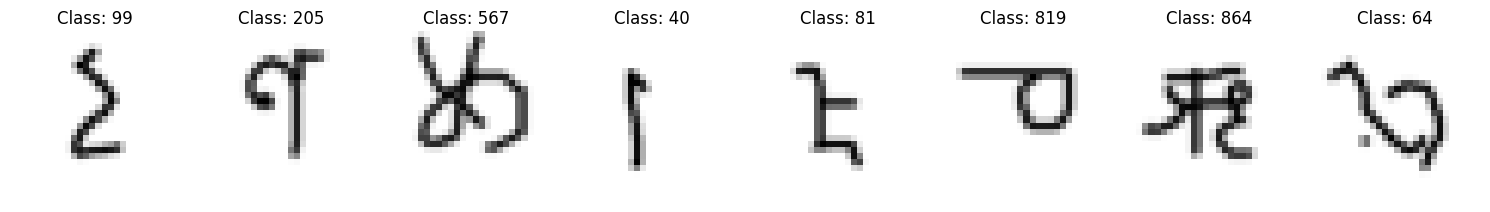

In [3]:
# Helper plotter functions
def plot_random_samples(dataset, num_samples=8):
    indices = np.random.choice(len(dataset), size=num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        x, y = dataset[idx]
        axes[i].imshow(x.squeeze(dim=0), cmap='gray')
        axes[i].set_title(f"Class: {torch.argmax(y)}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


def plot_class_samples(dataset, target_class, num_samples=8):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    count = 0
    for i in range(len(dataset)):
        x, y = dataset[i]
        if torch.argmax(y) == target_class:
            axes[count].imshow(x.squeeze(dim=0), cmap='gray')
            axes[count].set_title(f"Class: {target_class}")
            axes[count].axis('off')
            count += 1
        if count == num_samples:
            break
    plt.tight_layout()
    plt.show()

plot_random_samples(train_loader.dataset)

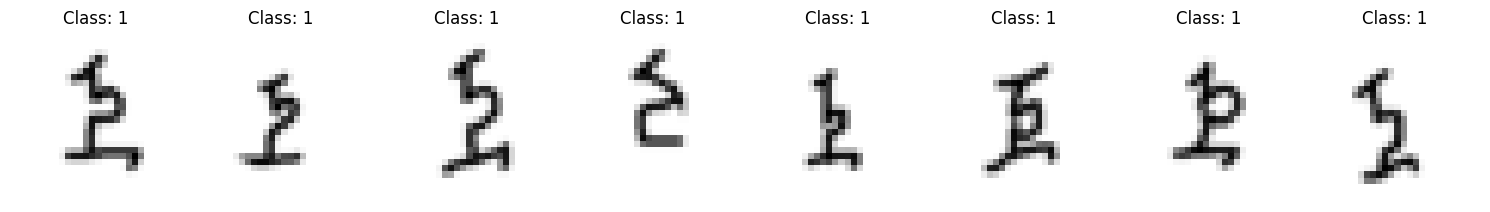

In [4]:
plot_class_samples(train_loader.dataset, 1)

# Model

In [5]:
# Model time
class ClassicKAN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            KAN(layers_hidden=[28*28, 256, num_classes], grid_size=2, spline_order=2)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)  # MSE Loss works best for NTK
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)  # MSE Loss works best for NTK
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("test loss (MSE Loss)", loss)
        self.log("accuracy", accuracy)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [ ]:
# Train + Test + Results
model = ClassicKAN()
trained_model = L.Trainer(max_epochs=10, deterministic=True, logger=CSVLogger("logs", name="OmniglotKANNTK"))
trained_model.fit(model, train_loader)
trained_model.test(model, test_loader)

# NTK Application
def check_ntk_acc(model, dataloader):
    res = 0.0
    sumlength = 0
    model.eval()
    model.to(device)
    for it in iter(dataloader):
        x, y = it
        x = x.to(device)
        y = y.to(device)
        sumlength += len(x)
        res += (torch.argmax(model(x), dim=1) == torch.argmax(y, dim=1)).sum()
    model.train()
    return res / sumlength

print(f'NTK Accuracy: {check_ntk_acc(model, test_loader)}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 3.7 M  | train
--------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.789    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
c:\Users\hugom\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
